In [1]:
from protos import scenario_pb2
from tensorflow.data import TFRecordDataset

2023-08-06 12:21:14.558092: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-06 12:21:14.592957: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-06 12:21:14.593503: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-06 12:21:15.617555: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os

def getFiles(path: str) -> list[str]:
    path = os.path.expanduser(path)
    files = [os.path.join(path, f) for f in os.listdir(path)]
    return [f for f in files if os.path.isfile(f)]

files = getFiles('~/data/waymo/')

In [3]:
import tqdm
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt

@dataclass
class State:
    heading: float
    velocity: np.ndarray


def parse_scenario(scenario: scenario_pb2.Scenario) -> list[State]:
    states = []
    for s in scenario.tracks[scenario.sdc_track_index].states:
        if s.valid:
            states.append(State(s.heading, np.array([s.velocity_x, s.velocity_y], dtype=np.float32)))
    return states


h: list[list[State]] = []

for file_path in tqdm.tqdm(files):
    for data in TFRecordDataset(file_path, compression_type="").as_numpy_iterator():
        scenario = scenario_pb2.Scenario()
        scenario.ParseFromString(data)
        h.append(parse_scenario(scenario))


  0%|          | 0/100 [00:00<?, ?it/s]

2023-08-06 12:21:16.608013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-06 12:21:16.625646: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
  3%|▎         | 3/100 [01:49<59:15, 36.65s/it]  


KeyboardInterrupt: 

In [4]:
print("trajectories: ", len(h))
if len(h) > 0:
    lens = [len(x) for x in h]
    print("avg len: ", sum(lens)/len(lens))

trajectories:  215
avg len:  198.51627906976745


In [5]:
def normalize_angle(angle: float) -> float:
    """
    Normalize the angle to [-pi, pi)
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

for s in h[4]:
    err = normalize_angle(np.arctan2(s.velocity[1], s.velocity[0])- s.heading)**2
    print(s.velocity[0], s.velocity[1])
    print(np.arctan2(s.velocity[1], s.velocity[0]), s.heading)

-0.6033403 -0.29557413
-2.6860607 -2.685227394104004
-0.63066554 -0.31144542
-2.6828883 -2.6853933334350586
-0.6925942 -0.3451719
-2.6792455 -2.6853065490722656
-0.75051224 -0.36821628
-2.6854773 -2.685509204864502
-0.80487454 -0.39107856
-2.6892986 -2.6857566833496094
-0.8647316 -0.42277873
-2.6868536 -2.685789108276367
-0.9241577 -0.45644513
-2.6828337 -2.685671091079712
-0.9855256 -0.4867216
-2.682861 -2.6856818199157715
-1.0384393 -0.5009156
-2.6921453 -2.6858057975769043
-1.0500392 -0.5094217
-2.6898992 -2.685610055923462
-1.0415444 -0.51445305
-2.6828105 -2.6852898597717285
-1.0481974 -0.5140947
-2.6856093 -2.685591697692871
-1.0570596 -0.5136322
-2.6892834 -2.6861698627471924
-1.0585835 -0.51602805
-2.6880188 -2.6862194538116455
-1.0543981 -0.5163588
-2.6862035 -2.6857070922851562
-1.0561582 -0.5174523
-2.6860268 -2.6856772899627686
-1.057772 -0.5175353
-2.6865664 -2.6860313415527344
-1.0525867 -0.5155731
-2.686126 -2.686190605163574
-1.0435711 -0.5168889
-2.681706 -2.6860704421

In [6]:
import random
# convert into a dataset of tuples (state, next_state)
dataset = []
for states in h:
    for i in range(len(states)-1):
        dataset.append((states[i], states[i+1]))

# shuffle the dataset
random.shuffle(dataset)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# create an idm that attempts to predict: throttle and steering
# given state at current timestep, and state at next timestep:
# each state contains: velocity_x (relative to original car heading), velocity_y (relative to original car heading), heading relative to original
class IDM(nn.Module):
    def __init__(self):
        super(IDM, self).__init__()
        # input shape: (batch_size, 6, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(3, 64, 2) # Bx3x2 -> Bx64x1
        self.fc1 = nn.Linear(64, 32) # Bx64 -> Bx32
        self.fc2 = nn.Linear(32, 2) # Bx32 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx3x2 -> Bx64x1
        x = torch.flatten(x, 1) # Bx64x1 -> Bx64
        x = F.relu(self.fc1(x)) # Bx64 -> Bx32
        x = self.fc2(x) # Bx32 -> Bx2
        return x


# How to train the Inverse Dynamics Model

An IDM (Inverse Dynamics Model) is a model that predicts the control input (steering angle and acceleration) given the current state of the vehicle and the next state of the vehicle. In RL parlance, we have $s_t$ and $s_{t+1}$ and we want to predict $a_t$.

We're training the IDM on the Waymo Motion Dataset. The dataset contains several thousand trajectories of vehicles driving in a variety of environments. The trajectories are sampled at 10Hz, and each sample contains the state of the vehicle (position, velocity, heading, etc.) and the environment (traffic lights, other vehicles, etc.). However, it does not contain the control input (steering angle and acceleration) of the vehicle. This is what we want to predict.

To do this, we'll leverage the Metadrive simulator. We reformulate the problem of predicting the action as a RL game where the model tries to take the action that will result in the next state in the simulator being as close as possible to the ground truth next state. The reward function is the negative of the distance between the predicted next state and the ground truth next state. We train the model using PPO. 

In [14]:
import metadrive
import gymnasium as gym
import typing


def compute_loss(env: gym.Env, st:State) -> float:
    # compute the error
    velocity_error = np.linalg.norm(env.vehicle.velocity[:2] - st1.velocity)
    
    # in order to prevent errors from wrapping around, we compare the difference in heading
    sim_heading_diff = normalize_angle(env.vehicle.heading_theta - st.heading)
    real_heading_diff = normalize_angle(st1.heading - st.heading)

    heading_error = (sim_heading_diff - real_heading_diff)**2
    
    return 1*velocity_error + 1000*heading_error

def run_game(env:gym.Env, policy:typing.Callable[[State, State], tuple[float, float]], st: State, st1: State) -> tuple[tuple[float, float], float]:
    """
    runs the policy and returns the total reward
    """
    
    # reset
    env.reset()
    env.vehicle.set_position(env.vehicle.position, height=0.49)

    # allow car to settle
    for _ in range(5):
        env.step([0,0])

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)
    
    # run the policy
    action = policy(st, st1)
    env.step(action)

    reward = -compute_loss(env, st1)

    if env.config.use_render:
        for _ in range(10):
            env.step([0,0])

    return action, reward

def obs_batch_to_tensor(obs: list[tuple[State, State]], device: torch.device) -> torch.Tensor:
    """
    Reshape the observation from tuple[State, State] to a tensor of shape (batch_size, 3, 2)
    """

    observations = []

    for st0, st1 in obs:
        theta = 0 #-st0.heading
        c, s = np.cos(theta), np.sin(theta)
        R = np.array(((c, -s), (s, c)))

        st0v = R @ st0.velocity
        st1v = R @ st1.velocity

        observations.append(np.array([
            [st0v[0], st1v[0]], 
            [st0v[1], st1v[1]],
            [0, normalize_angle(st1.heading-st0.heading)]
        ]))

    return torch.tensor(np.stack(observations), dtype=torch.float32, device=device)


def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

In [9]:
class Actor(nn.Module):
    def __init__(self, idm: IDM):
        super().__init__()
        self.idm = idm

    def forward(self, x: torch.Tensor) -> torch.distributions.MultivariateNormal:
        mu = self.idm(x)
        # sigma is fixed at 0.05
        sigma = 0.1*torch.ones_like(mu)
        return torch.distributions.MultivariateNormal(mu, torch.diag_embed(sigma))

class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 6, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(3, 64, 2) # Bx3x2 -> Bx64x1
        self.fc1 = nn.Linear(64, 32) # Bx64 -> Bx32
        self.fc2 = nn.Linear(32, 1) # Bx32 -> Bx1
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx3x2 -> Bx64x1
        x = torch.flatten(x, 1) # Bx64x1 -> Bx64
        x = F.relu(self.fc1(x)) # Bx64 -> Bx32
        x = self.fc2(x) # Bx32 -> Bx1
        output = torch.squeeze(x, dim=1) # Bx1 -> B
        return output

class ActorPolicy:
    def __init__(self, net: Actor):
        self.net = net

    def __call__(self, st: State, st1: State) -> tuple[float, float]:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([(st, st1)], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            throttle, steering = self.net(obs_tensor).sample()[0]
        return throttle.item(), steering.item()

class IDMPolicy:
    def __init__(self, net: IDM):
        self.net = net

    def __call__(self, st: State, st1: State) -> tuple[float, float]:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([(st, st1)], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            throttle, steering = self.net(obs_tensor)[0]
        return throttle.item(), steering.item()

def compute_advantage(critic:Critic, st0:State, st1: State, reward: float) -> float:
    with torch.no_grad():
        return float(reward - critic(obs_batch_to_tensor([(st0, st1)], deviceof(critic)))[0])

@dataclass
class PPOConfig:
    ppo_eps: float
    ppo_grad_descent_steps: int

def compute_ppo_loss(
    # Old policy network's distribution of actions given a state
    # inner shape = (Batch, 2)
    pi_thetak_given_st: torch.distributions.MultivariateNormal,
    # Current policy network's distribution of actions given a state
    # in (Batch, Action)
    pi_theta_given_st: torch.distributions.MultivariateNormal,
    # The action chosen by the old policy network
    # in (Batch, 2)
    a_t: torch.Tensor,
    # Advantage of the chosen action
    # in (Batch,)
    A_pi_thetak_given_st_at: torch.Tensor,
    # configuration options
    config: PPOConfig
) -> torch.Tensor:
    # the likelihood ratio (used to penalize divergence from the old policy)
    # in (Batch,)
    likelihood_ratio = torch.exp(pi_theta_given_st.log_prob(a_t) - pi_thetak_given_st.log_prob(a_t))

    # in (Batch,)
    ppo_loss_per_example = -torch.minimum(
        likelihood_ratio * A_pi_thetak_given_st_at,
        torch.clip(likelihood_ratio, 1 - config.ppo_eps, 1 + config.ppo_eps) * A_pi_thetak_given_st_at,
    )

    loss_per_example = ppo_loss_per_example

    # we take the average loss over all examples
    return loss_per_example.mean()

def train_ppo(
    actor: Actor,
    critic: Critic,
    actor_optimizer: torch.optim.Optimizer,
    critic_optimizer: torch.optim.Optimizer,
    observation_batch: list[tuple[State, State]],
    action_batch: list[tuple[float, float]],
    advantage_batch: list[float],
    reward_to_go_batch: list[float],
    config: PPOConfig
) -> tuple[list[float], list[float]]:
    # assert that the models are on the same device
    assert deviceof(critic) == deviceof(actor)
    # assert that the batch_lengths are the same
    assert len(observation_batch) == len(action_batch)
    assert len(observation_batch) == len(advantage_batch)
    assert len(observation_batch) == len(reward_to_go_batch)

    # get device
    device = deviceof(critic)

    # convert data to tensors on correct device

    # in (Batch, Width, Height)
    observation_batch_tensor = obs_batch_to_tensor(observation_batch, device)

    # the true V^pi(s) is reward to go
    # in (Batch,)
    true_value_batch_tensor = torch.tensor(
        reward_to_go_batch, dtype=torch.float32, device=device
    )

    # in (Batch, 2)
    chosen_action_tensor = torch.tensor(action_batch, device=device)

    # in (Batch,)
    advantage_batch_tensor = torch.tensor(advantage_batch, device=device)

    # train critic
    critic_optimizer.zero_grad()
    pred_value_batch_tensor = critic.forward(observation_batch_tensor)
    critic_loss = F.mse_loss(pred_value_batch_tensor, true_value_batch_tensor)
    critic_loss.backward()
    critic_optimizer.step()

    # train actor

    # Recall that in the PPO algorithm, we need to set theta to the *optimal* theta with respect to the surrogate loss function,
    # as opposed to the standard policy gradient, where we just update theta.

    # Here's what that means:
    # We have a policy network with parameters theta_k
    # We want to find the optimal theta, theta*, that maximizes the surrogate loss function L_CLIP(theta, theta_k)
    # Note: In practice, we just use gradient descent for PPO_GRAD_DESCENT_STEPS steps to approximate theta*, since we can't analytically solve for theta*
    # We then update: theta_k <- theta*

    # The amount theta* can diverge from theta_k is limited by L_CLIP(theta, theta_k).
    # This is because we want to avoid the new policy diverging too far from the old policy, since that can lead to instability.

    # the old_policy_action_probs are the the predictions made by the pre-train-step network that we want to not diverge too far away from
    # in (Batch, Action)
    with torch.no_grad():
        old_policy_action_probs = actor.forward(observation_batch_tensor)

    actor_losses = []
    for _ in range(config.ppo_grad_descent_steps):
        actor_optimizer.zero_grad()
        current_policy_action_probs = actor.forward(observation_batch_tensor)
        actor_loss = compute_ppo_loss(
            old_policy_action_probs,
            current_policy_action_probs,
            chosen_action_tensor,
            advantage_batch_tensor,
            config
        )
        actor_loss.backward()
        actor_optimizer.step()
        actor_losses.append(float(actor_loss))


    # return the respective losses
    return actor_losses, [float(critic_loss)]*config.ppo_grad_descent_steps

In [21]:
def set_lr(optimizer: torch.optim.Optimizer, lr: float) -> None:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

idm = IDM().to(device)
actor = Actor(idm)
critic = Critic().to(device)

actor_optimizer = torch.optim.Adam(actor.parameters())
critic_optimizer = torch.optim.Adam(critic.parameters())

dataset_iterator = iter(dataset)

step = 0
returns = []
actor_losses = []
critic_losses = []

In [11]:
# disable logging from metadrive
import logging
import inspect
import metadrive.envs.base_env
logging.getLogger(inspect.getfile(metadrive.envs.base_env)).setLevel(logging.WARNING)

In [50]:
env = gym.make("MetaDrive-validation-v0", config={"on_continuous_line_done": False, "use_render": False})

In [51]:
set_lr(actor_optimizer, 1e-5)
CONFIG = PPOConfig(
    ppo_eps=0.15,
    ppo_grad_descent_steps=10,
)
# the critic has to learn faster than the actor
set_lr(critic_optimizer, 3e-3)

TRAIN_EPOCHS = 100
EPISODES_PER_BATCH = 1024

# Train
while step < TRAIN_EPOCHS:
    obs_batch:list[tuple[State, State]] = []
    act_batch:list[tuple[float, float]] = []
    rtg_batch:list[float] = []
    adv_batch:list[float] = []
    
    trajectory_returns = []

    for _ in range(EPISODES_PER_BATCH):
        st0, st1 = next(dataset_iterator)
        # Collect trajectory
        action, reward = run_game(env, ActorPolicy(actor), st0, st1)

        # Update batch
        obs_batch.append((st0, st1))
        act_batch.append(action)
        rtg_batch.append(reward)
        adv_batch.append(compute_advantage(critic, st0, st1, reward))

        # Update trajectory returns
        trajectory_returns.append(reward)

    batch_actor_losses, batch_critic_losses = train_ppo(
        actor,
        critic,
        actor_optimizer,
        critic_optimizer,
        obs_batch,
        act_batch,
        adv_batch,
        rtg_batch,
        CONFIG,
    )

    # collect statistics
    returns.append(trajectory_returns)
    actor_losses.extend(batch_actor_losses)
    critic_losses.extend(batch_critic_losses)

    print(f"Step {step}, Avg. Returns: {np.mean(trajectory_returns):.3f} +/- {np.std(trajectory_returns):.3f}, Median: {np.median(trajectory_returns):.3f}, Actor Loss: {actor_losses[-1]:.3f}, Critic Loss: {batch_critic_losses[-1]:.3f}")

    step += 1

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


Step 27, Avg. Returns: -0.399 +/- 0.484, Median: -0.324, Actor Loss: 0.021, Critic Loss: 0.198
Step 28, Avg. Returns: -0.364 +/- 0.434, Median: -0.271, Actor Loss: -0.024, Critic Loss: 0.141
Step 29, Avg. Returns: -0.401 +/- 0.482, Median: -0.363, Actor Loss: -0.004, Critic Loss: 0.189
Step 30, Avg. Returns: -0.385 +/- 0.436, Median: -0.312, Actor Loss: -0.012, Critic Loss: 0.149
Step 31, Avg. Returns: -0.422 +/- 0.486, Median: -0.394, Actor Loss: 0.021, Critic Loss: 0.193
Step 32, Avg. Returns: -0.390 +/- 0.451, Median: -0.341, Actor Loss: -0.006, Critic Loss: 0.162
Step 33, Avg. Returns: -0.423 +/- 0.564, Median: -0.352, Actor Loss: 0.038, Critic Loss: 0.278
Step 34, Avg. Returns: -0.395 +/- 0.489, Median: -0.324, Actor Loss: 0.012, Critic Loss: 0.201
Step 35, Avg. Returns: -0.394 +/- 0.503, Median: -0.296, Actor Loss: 0.019, Critic Loss: 0.205
Step 36, Avg. Returns: -0.402 +/- 0.471, Median: -0.382, Actor Loss: 0.013, Critic Loss: 0.177
Step 37, Avg. Returns: -0.386 +/- 0.470, Media

KeyboardInterrupt: 

In [49]:
env.close()

Let's try visualizing our IDM by having it follow a scenario from start to finish.

In [47]:
env = gym.make("MetaDrive-validation-v0", config={"on_continuous_line_done": False, "use_render": True})

In [48]:
scenario = h[5]
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        action = IDMPolicy(idm)(st0, st1)
        print(action)
        print(compute_loss(env, st1))
        env.step(action)
        

/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:210: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


(0.1975921094417572, 0.16340357065200806)
0.17714485681455253
(0.19733494520187378, 0.16290917992591858)
1.2593791755710537
(0.1990598887205124, 0.16415134072303772)
4.845937814139897
(0.20098876953125, 0.16489040851593018)
14.837279955246226
(0.20202969014644623, 0.16610828042030334)
34.766595861605225
(0.2026030421257019, 0.16747498512268066)
66.74870474612854
(0.2026040107011795, 0.16822168231010437)
111.69950952293713
(0.20263968408107758, 0.16905489563941956)
170.13950814792344
(0.20252440869808197, 0.16964218020439148)
242.18699585972547
(0.2027777135372162, 0.170407235622406)
328.01221704936205
(0.20254181325435638, 0.1711929738521576)
427.2211465927979
(0.20200243592262268, 0.17136579751968384)
539.915453194584
(0.20323337614536285, 0.1732129454612732)
671.0630404988116
(0.20484337210655212, 0.17545375227928162)
826.7662030844434
(0.20415863394737244, 0.1782943308353424)
986.5122135520003
(0.20172983407974243, 0.18165823817253113)
1098.4590134969387
(0.19959846138954163, 0.1834

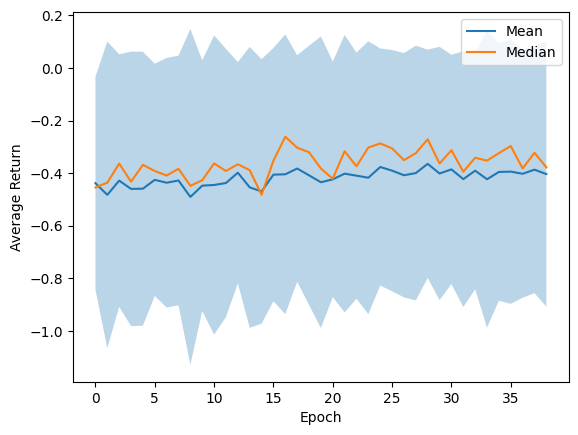

In [52]:
import matplotlib.pyplot as plt
return_medians = [np.median(returns[i]) for i in range(len(returns))]
return_means = [np.mean(returns[i]) for i in range(len(returns))]
return_stds = [np.std(returns[i]) for i in range(len(returns))]
plt.plot(return_means, label="Mean")
plt.plot(return_medians, label="Median")
plt.fill_between(range(len(return_means)), np.array(return_means) - np.array(return_stds), np.array(return_means) + np.array(return_stds), alpha=0.3)
plt.xlabel("Epoch")
plt.ylabel("Average Return")
plt.legend()
plt.show()

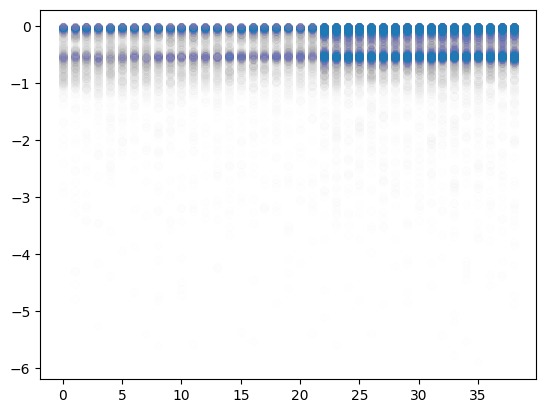

In [53]:
# scatter plot of the returns
xs = []
ys = []
for t, rets in enumerate(returns):
    for ret in rets:
        xs.append(t)
        ys.append(ret)
plt.scatter(xs, ys, alpha=0.002)

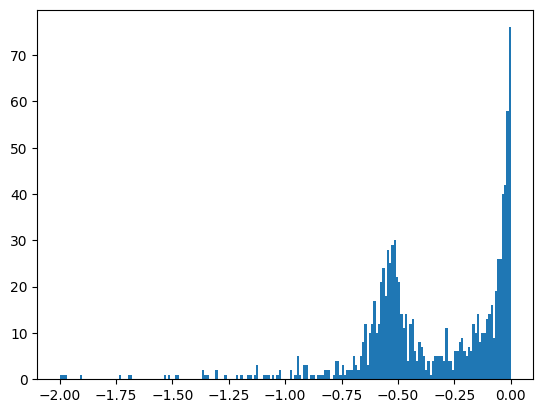

In [54]:
returns_no_outlier = [r for r in returns[-1] if r > -2]
plt.hist(returns_no_outlier, bins=200)
plt.show()

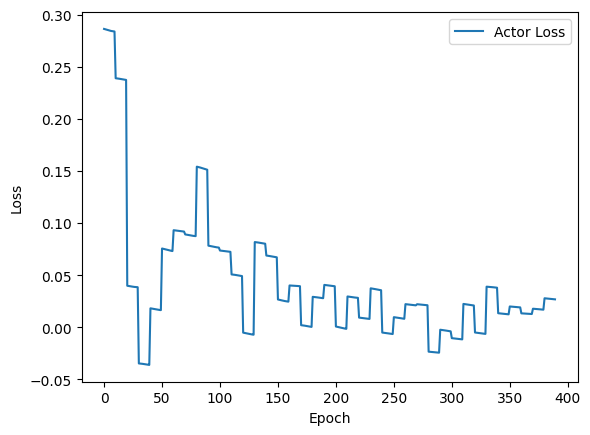

In [55]:
# plot actor losses
plt.plot(actor_losses[:], label="Actor Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

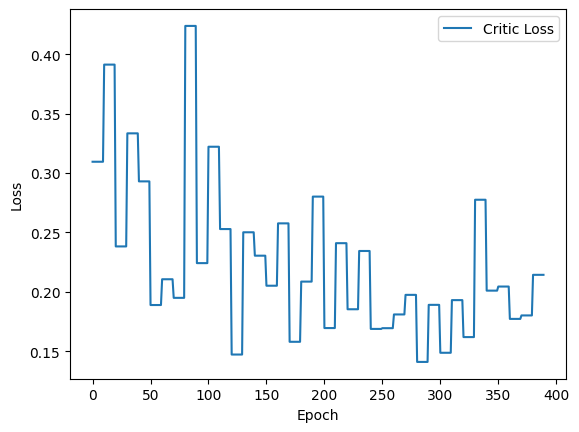

In [56]:
# plot critic losses
plt.plot(critic_losses, label="Critic Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [58]:
adv_batch

[tensor(0.1521, device='cuda:0'),
 tensor(0.1746, device='cuda:0'),
 tensor(0.1956, device='cuda:0'),
 tensor(0.1534, device='cuda:0'),
 tensor(-0.1018, device='cuda:0'),
 tensor(0.0080, device='cuda:0'),
 tensor(0.0507, device='cuda:0'),
 tensor(-0.0097, device='cuda:0'),
 tensor(0.1629, device='cuda:0'),
 tensor(0.1591, device='cuda:0'),
 tensor(0.0004, device='cuda:0'),
 tensor(-0.0774, device='cuda:0'),
 tensor(0.1543, device='cuda:0'),
 tensor(-0.0900, device='cuda:0'),
 tensor(0.1141, device='cuda:0'),
 tensor(-0.1147, device='cuda:0'),
 tensor(0.1687, device='cuda:0'),
 tensor(0.2139, device='cuda:0'),
 tensor(0.2060, device='cuda:0'),
 tensor(0.1652, device='cuda:0'),
 tensor(0.1746, device='cuda:0'),
 tensor(0.1428, device='cuda:0'),
 tensor(0.1653, device='cuda:0'),
 tensor(0.0831, device='cuda:0'),
 tensor(-0.0774, device='cuda:0'),
 tensor(0.1163, device='cuda:0'),
 tensor(-0.0225, device='cuda:0'),
 tensor(0.0995, device='cuda:0'),
 tensor(-0.3754, device='cuda:0'),
 tenso